In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import extract_correct_csv
import neurokit2 as nk
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

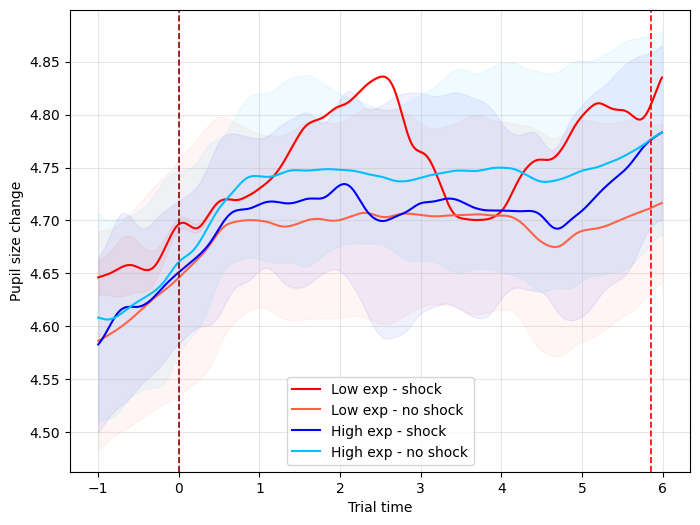

In [33]:
columns = list(pd.read_csv('../osfstorage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_
generic_df = pd.DataFrame(columns=columns)
cur_sub = extract_correct_csv.read_correct_subject_csv(55)
subject = pd.read_csv('data/LookAtMe_0' + cur_sub + '.csv', sep='\t')
pupil_subj = pd.read_csv('../osfstorage-archive/eye/pupil/Look0' + cur_sub + '_pupil.csv', sep=';', decimal=',')
expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
df_ = pupil_subj.copy(deep=False)
df_['expectancy'] = expectancy
df_['shock'] = subject['shock']
generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)
all_conf_1 = df_LE_shock.var(axis=0)

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)
all_conf_2 = df_LE_no_shock.std(axis=0)

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)
all_conf_3 = df_HE_shock.std(axis=0)

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)
all_conf_4 = df_HE_no_shock.std(axis=0)

from matplotlib.pyplot import figure

figure(figsize=(8, 6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color='r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color='tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color='b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color='deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()

## All valid subject

In [2]:
valid_subject = extract_correct_csv.extract_only_valid_subject()
valid_subject

[2, 4, 10, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

In [3]:
columns = list(pd.read_csv('../osfstorage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_

In [4]:
generic_df = pd.DataFrame(columns=columns)
for x in valid_subject:
    cur_sub = extract_correct_csv.read_correct_subject_csv(x)
    subject = pd.read_csv('data/LookAtMe_0'+cur_sub+'.csv', sep='\t')
    pupil_subj = pd.read_csv('../osfstorage-archive/eye/pupil/Look0'+cur_sub+'_pupil.csv', sep=';', decimal=',')
    expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
    df_ = pupil_subj.copy(deep=False)
    df_['expectancy'] = expectancy
    df_['shock'] = subject['shock']
    generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])

In [5]:
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]

In [6]:
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
mean_baseline

2.3951070719941048

In [30]:
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)
all_conf_1 = df_LE_shock.var(axis=0)

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)
all_conf_2 = df_LE_no_shock.std(axis=0)

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)
all_conf_3 = df_HE_shock.std(axis=0)

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)
all_conf_4 = df_HE_no_shock.std(axis=0)


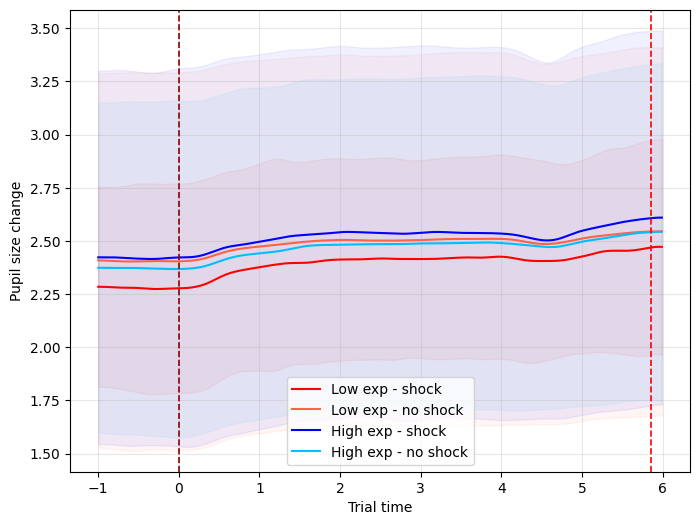

In [31]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color = 'r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color = 'tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color = 'b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color = 'deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()

## Single signal eda

In [9]:
valid_subject = extract_correct_csv.extract_only_valid_subject()

not_valid = {4, 43, 45, 50, 55}

valid_subject = [ele for ele in valid_subject if ele not in not_valid]

In [18]:
subject = pd.read_csv('data/sync_signals_raw/eda_csv/55_eda.csv')
shock_csv = pd.read_csv('csv_shock.csv')
shock_csv = shock_csv.drop(columns=shock_csv.columns[0])

eda_processed = []

for x in range(len(subject)):
    row = subject.loc[x]
    signals, info = nk.eda_process(row, sampling_rate=500)
    eda_processed.append(signals['EDA_Phasic'].to_numpy())
eda_processed = pd.DataFrame(eda_processed)

In [19]:
df_eda = eda_processed.copy(deep=False)
shock_sub = shock_csv[shock_csv.subject==55]
expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
df_eda['expectancy'] = expectancy
df_eda['shock'] = shock_sub['shock'].to_numpy()

In [25]:
X = np.arange(0, 6, 0.002)
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_sing_LE_shock = df_EDA_LE_shock.std(axis=0)

# - low exp and no shock
df_EDA_LE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_no= df_EDA_LE_no.mean(axis=0)
conf_sing_LE_no = df_EDA_LE_no.std(axis=0)

# - high exp and shock
df_EDA_HE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_sing_HE_shock = df_EDA_HE_shock.std(axis=0)

# - high exp and no shock
df_EDA_HE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_no = df_EDA_HE_no.mean(axis=0)
conf_sing_HE_no = df_EDA_HE_no.std(axis=0)

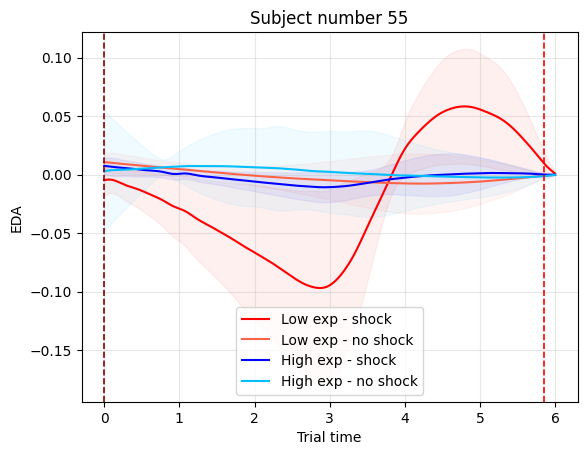

In [27]:
plt.plot(X, mean_sing_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_sing_LE_shock - conf_sing_LE_shock, mean_sing_LE_shock + conf_sing_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_sing_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_sing_LE_no - conf_sing_LE_no, mean_sing_LE_no + conf_sing_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_sing_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_sing_HE_shock - conf_sing_HE_shock, mean_sing_HE_shock + conf_sing_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_sing_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_sing_HE_no - conf_sing_HE_no, mean_sing_HE_no + conf_sing_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.title(f'Subject number {str(55)}')
plt.show()

## All subjects EDA

In [14]:
columns_eda = list(eda_processed.columns)
col_ = ['expectancy', 'shock']
columns_eda = columns_eda + col_

In [22]:
shock_csv

,subject,trial,rating,shock
0,2,1,3.0,False
1,2,2,3.0,False
2,2,3,3.0,False
3,2,4,3.0,False
4,2,5,3.0,False
...,...,...,...,...
2715,55,156,1.0,False
2716,55,157,1.0,False
2717,55,158,1.0,False
2718,55,159,1.0,False


In [15]:
global_eda = pd.DataFrame(columns=columns_eda)
for i in valid_subject:
    subject = pd.read_csv('data/sync_signals_raw/eda_csv/'+str(i)+'_eda.csv')
    shock_csv = pd.read_csv('csv_shock.csv')
    shock = shock_csv.drop(columns=shock_csv.columns[0])
    eda_processed = []
    for x in range(len(subject)):
        row = subject.loc[x]
        signals, info = nk.eda_process(row, sampling_rate=500)
        eda_processed.append(signals['EDA_Phasic'].to_numpy())
    eda_processed = pd.DataFrame(eda_processed)
    df_eda_all = eda_processed.copy(deep=False)
    shock_sub = shock_csv[shock.subject==i]
    expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
    df_eda_all['expectancy'] = expectancy
    df_eda_all['shock'] = shock_sub['shock'].to_numpy()
    global_eda = pd.concat([global_eda, df_eda_all], axis=0)


In [16]:
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = global_eda[(global_eda.shock == True) & (global_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_all_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_all_LE_shock = df_EDA_LE_shock.std(axis=0)

# - low exp and no shock
df_EDA_LE_no = global_eda[(global_eda.shock == False) & (global_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_all_LE_no= df_EDA_LE_no.mean(axis=0)
conf_all_LE_no = df_EDA_LE_no.std(axis=0)

# - high exp and shock
df_EDA_HE_shock = global_eda[(global_eda.shock == True) & (global_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_all_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_all_HE_shock = df_EDA_HE_shock.std(axis=0)

# - high exp and no shock
df_EDA_HE_no = global_eda[(global_eda.shock == False) & (global_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_all_HE_no = df_EDA_HE_no.mean(axis=0)
conf_all_HE_no = df_EDA_HE_no.std(axis=0)

In [24]:
global_eda[(global_eda.shock == False) & (global_eda.expectancy == 1)]

,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,expectancy,shock
0,0.004109,0.003959,0.003809,0.003659,0.003509,0.003360,0.003211,0.003062,0.002915,0.002768,...,0.000044,0.000042,0.000039,0.000036,0.000033,0.000031,0.000028,0.000025,1,False
1,-0.010901,-0.010909,-0.010916,-0.010924,-0.010931,-0.010939,-0.010947,-0.010955,-0.010963,-0.010971,...,0.000035,0.000033,0.000031,0.000029,0.000026,0.000024,0.000022,0.000019,1,False
2,-0.000348,-0.000334,-0.000320,-0.000306,-0.000292,-0.000278,-0.000265,-0.000251,-0.000237,-0.000223,...,-0.000210,-0.000197,-0.000184,-0.000171,-0.000158,-0.000145,-0.000132,-0.000118,1,False
3,0.000745,0.000797,0.000848,0.000900,0.000951,0.001002,0.001053,0.001104,0.001154,0.001204,...,0.000224,0.000210,0.000196,0.000182,0.000168,0.000154,0.000140,0.000126,1,False
4,-0.007507,-0.007553,-0.007598,-0.007643,-0.007687,-0.007731,-0.007775,-0.007819,-0.007862,-0.007904,...,-0.000093,-0.000087,-0.000082,-0.000076,-0.000070,-0.000064,-0.000058,-0.000052,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,0.003112,0.003235,0.003357,0.003479,0.003601,0.003722,0.003842,0.003961,0.004079,0.004197,...,-0.000177,-0.000166,-0.000154,-0.000143,-0.000132,-0.000121,-0.000110,-0.000099,1,False
136,0.006863,0.006718,0.006573,0.006428,0.006283,0.006138,0.005993,0.005848,0.005704,0.005561,...,-0.000178,-0.000166,-0.000155,-0.000144,-0.000133,-0.000122,-0.000111,-0.000100,1,False
147,0.001158,0.001276,0.001394,0.001512,0.001629,0.001745,0.001861,0.001977,0.002091,0.002205,...,-0.000087,-0.000082,-0.000076,-0.000071,-0.000065,-0.000060,-0.000054,-0.000049,1,False
153,0.004421,0.004462,0.004503,0.004544,0.004585,0.004625,0.004665,0.004704,0.004743,0.004781,...,-0.000177,-0.000166,-0.000155,-0.000144,-0.000133,-0.000122,-0.000111,-0.000100,1,False


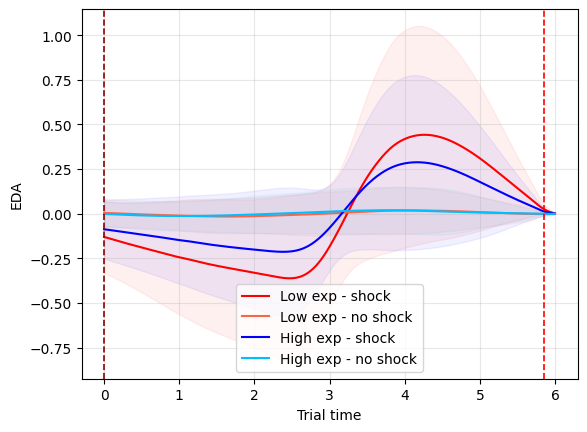

In [17]:
plt.plot(X, mean_all_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_all_LE_shock - conf_all_LE_shock, mean_all_LE_shock + conf_all_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_all_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_all_LE_no - conf_all_LE_no, mean_all_LE_no + conf_all_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_all_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_all_HE_shock - conf_all_HE_shock, mean_all_HE_shock + conf_all_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_all_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_all_HE_no - conf_all_HE_no, mean_all_HE_no + conf_all_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.show()

## Plot signal single subject EDA fake

In [41]:
fake_single = pd.read_csv('data_fake/eda_csv/2_eda.csv')

eda_processed = []
for x in range(len(fake_single)):
    row = fake_single.loc[x]
    signals, info = nk.eda_process(row, sampling_rate=500)
    eda_processed.append(signals['EDA_Phasic'].to_numpy())
eda_processed = pd.DataFrame(eda_processed)

In [42]:
df_eda_fake = eda_processed.copy(deep=False)
shock_sub = shock_csv[shock_csv.subject==2]
expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
df_eda_fake['expectancy'] = expectancy

In [56]:
# low exp
low_exp = df_eda_fake[df_eda_fake.expectancy == 0].drop(columns=['expectancy'])
mean_low_exp = low_exp.mean(axis=0)
var_low_exp = low_exp.std(axis=0)

# high exp
high_exp = df_eda_fake[df_eda_fake.expectancy == 1].drop(columns=['expectancy'])
mean_high_exp = high_exp.mean(axis=0)
var_high_exp = high_exp.std(axis=0)

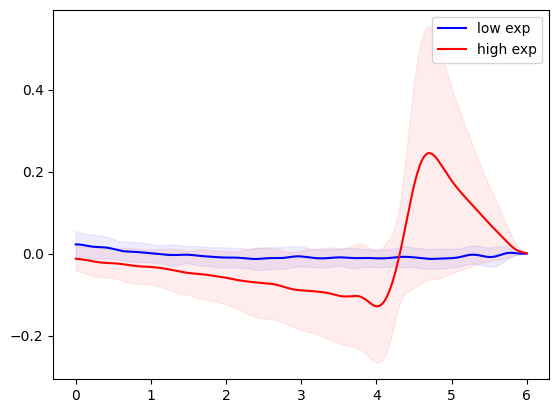

In [57]:
X = np.arange(0, 6, 0.002)

plt.plot(X, mean_low_exp, 'b-', label='low exp')
plt.fill_between(X, mean_low_exp-var_low_exp, mean_low_exp+var_low_exp, color='b', alpha=0.07)

plt.plot(X, mean_high_exp, 'r-', label='high exp')
plt.fill_between(X, mean_high_exp-var_high_exp, mean_high_exp+var_high_exp, color='r', alpha=0.07)
plt.legend()
plt.show()

In [ ]:
# all subjects

